# DSC 291: Libraries and Tools

We will be using the LFW dataset, helper functions, and our own solutions from HW1_Q3 for this experiment.

# Experiment Part 1

In [35]:
import tensorflow as tf
import torch
import numpy as np

A_np = np.array([[3.,2.,2.],[2.,3.,-2.]])

U_n,S_n,V_n = np.linalg.svd(A_np, full_matrices=False,compute_uv=True)
print(f"U: \n {U_n}")
print(f"S: \n {S_n}")
print(f"V: \n {V_n.T}")

U: 
 [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
S: 
 [5. 3.]
V: 
 [[-7.07106781e-01 -2.35702260e-01]
 [-7.07106781e-01  2.35702260e-01]
 [-6.47932334e-17 -9.42809042e-01]]


In [2]:
A_torch = torch.from_numpy(A_np)
U_to,S_to,V_to = torch.svd(A_torch)
print(f"U: \n {U_to}")
print(f"S: \n {S_to}")
print(f"V: \n {V_to}")

U: 
 tensor([[-0.7071, -0.7071],
        [-0.7071,  0.7071]], dtype=torch.float64)
S: 
 tensor([5.0000, 3.0000], dtype=torch.float64)
V: 
 tensor([[-7.0711e-01, -2.3570e-01],
        [-7.0711e-01,  2.3570e-01],
        [-5.5511e-17, -9.4281e-01]], dtype=torch.float64)


In [3]:
A_tf = tf.convert_to_tensor(A_np)
S_tf, U_tf, V_tf = tf.linalg.svd(A_tf)
print(f"U: \n {U_tf}")
print(f"S: \n {S_tf}")
print(f"V: \n {V_tf}")

U: 
 [[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]
S: 
 [5. 3.]
V: 
 [[-0.70710678  0.23570226]
 [-0.70710678 -0.23570226]
 [ 0.          0.94280904]]


# Experiment Part 2
## Load Data and Helper Functions

In [4]:
# loading the dataset directly from the scikit-learn library (can take about 3-5 mins)
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score
dataset = fetch_lfw_people(min_faces_per_person=80)
count, height, width = dataset.images.shape
print('The shape of data is:',dataset.data.shape)

The shape of data is: (1140, 2914)


In [5]:
# !!DO NOT EDIT!!
# create target label - target name pairs
targets = [(x,y) for x,y in zip(range(len(np.unique(dataset.target))), dataset.target_names)]
print('The target labels and names are:\n', targets)

The target labels and names are:
 [(0, 'Colin Powell'), (1, 'Donald Rumsfeld'), (2, 'George W Bush'), (3, 'Gerhard Schroeder'), (4, 'Tony Blair')]


In [6]:
# !!DO NOT EDIT!!
# Helper function to plot
import matplotlib.pyplot as plt
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

## Data Preprocessing

In [7]:
X, y = dataset.data, dataset.target

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train[:5, :5])

[[-0.9654279  -1.029501   -1.0190299  -0.7276614  -0.60200846]
 [ 2.5243914   2.3122554   1.5580603   0.7567846   0.28822848]
 [-1.0716397  -1.0915289  -1.1379725  -0.93516475  1.2346063 ]
 [ 0.09669104 -0.02154656 -0.5432594  -1.1666106  -1.0751973 ]
 [ 0.02841197 -0.03705349 -0.08334781 -0.21688434 -0.07267851]]


In [9]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=True)

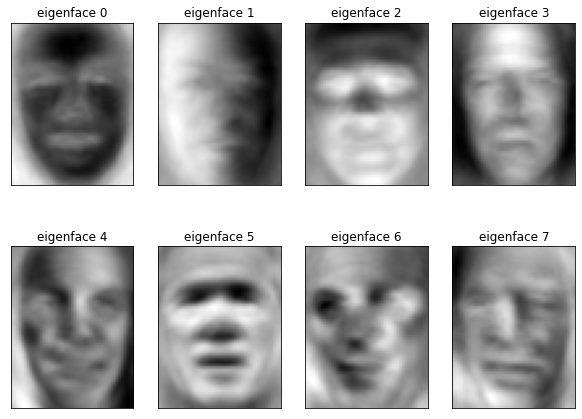

In [10]:
# !!DO NOT EDIT!!
# get the 100 eigen faces and reshape them to original image size which is 62 x 47 pixels 
eigenfaces = pca.components_.reshape((n_components, height, width))

# plot the top 8 eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

plt.show()

## Train A PyTorch Model
Benchmark the time to converge for 3 identical MLPs.

### Convert Data to PyTorch Tensors

In [11]:
import torch
import torch.nn as nn

X_train_pca, X_test_pca = pca.transform(X_train), pca.transform(X_test)

X_train_pca_torch, X_test_pca_torch = torch.from_numpy(X_train_pca), torch.from_numpy(X_test_pca)
y_train_torch, y_test_torch = torch.from_numpy(y_train).long(), torch.from_numpy(y_test).long()


### Define PyTorch Architecture

In [12]:
class Torch_MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100,1024)
        self.fc2 = nn.Linear(1024, 5)
        self.relu = torch.nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.log_softmax(x)
        return x

### Train using Autograd

In [13]:
import time 
criterion = torch.nn.NLLLoss()

pytorch_times = []
pytorch_accuracies = []
for i in range(12):
    start_t = time.time()
    model = Torch_MLP()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
    for epoch in range(500):
        # reset gradients
        optimizer.zero_grad()

        # predict
        output=model(X_train_pca_torch)

        # calculate loss
        loss=criterion(output, y_train_torch)

        # backpropagate loss
        loss.backward()

        # performs a single gradient update step
        optimizer.step()
    pytorch_times.append(time.time() - start_t)
    

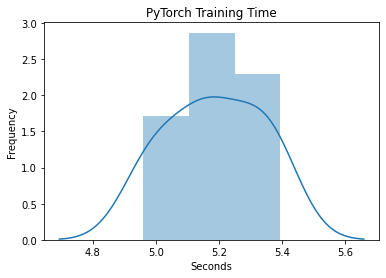

In [14]:
import seaborn as sn
plt.title("PyTorch Training Time")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
sn.distplot(pytorch_times)
plt.show()

In [15]:
np.mean(pytorch_times), np.std(pytorch_times), np.var(pytorch_times)

(5.1852467854817705, 0.14513553186147, 0.02106432260871177)

## Tensorflow

In [16]:
import tensorflow as tf


class Tf_MLP(tf.Module):
    
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(1024))
        self.model.add(tf.keras.layers.ReLU())
        self.model.add(tf.keras.layers.Dense(5))
        self.model.add(tf.keras.layers.Softmax())
       
    def forward(self, x):
        return self.model(x)

In [17]:
X_train_pca, X_test_pca = pca.transform(X_train), pca.transform(X_test)
X_train_pca_tf, X_test_pca_tf = tf.convert_to_tensor(X_train_pca),  tf.convert_to_tensor(X_test_pca)
y_train_tf, y_test_tf = tf.convert_to_tensor(y_train), tf.convert_to_tensor(y_test)

In [18]:
from tensorflow import keras
import time

optimizer = keras.optimizers.SGD(learning_rate=1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()

@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model.forward(x)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


In [19]:

tensorflow_times = []
model = Tf_MLP()
for i in range(12):
    start_time = time.time()

    for epoch in range(500):

        loss_value = train_step(X_train_pca_tf, y_train_tf)

            
    tensorflow_times.append(time.time() - start_time)

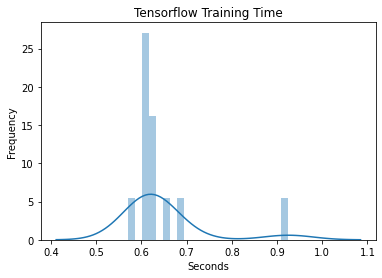

In [20]:
plt.title("Tensorflow Training Time")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
sn.distplot(tensorflow_times)
plt.show()

In [21]:
np.mean(tensorflow_times), np.std(tensorflow_times), np.var(tensorflow_times)

(0.6474982500076294, 0.08757406706670463, 0.007669217222603682)

## Numpy

In [22]:
def softmax(x):
    '''
    Input
         x: a vector in ndarray format, 
            typically the raw score of prediction.
    Output 
         a vector in ndarray format,
         typically representing the predicted class probability.
    '''
    res = np.exp(x-np.max(x))
    return res/np.sum(res)

def cross_entropy(y, p):
    '''
    Input
        y: an int representing the class label
        p: a vector in ndarray format showing the predicted
           probability of each class.
           
    Output
        the cross entropy loss. 
    '''
    log_likelihood = -np.log(p)
    return log_likelihood[y]

def relu(x):
    '''
    Input
        x: a vector in ndarray format
    Output
        a vector in ndarray format,
        representing the ReLu activation of x.
    '''
    return np.maximum(x, 0)

In [23]:
class Numpy_MLP():
    '''
    This class defines the multi-layer perceptron we will be using
    with Numpy.
    
    '''
    def __init__(self):
        
        
        # Not Including a bias
        self.W1 = np.random.normal(size=(100,1024))
        self.W2 = np.random.normal(size=(1024,5))
        

    def forward(self, x):
        '''
        This method finds the predicted probability vector of an input
        image x.
        
        Input
            x: a single image vector in ndarray format
        Ouput
            a vector in ndarray format representing the predicted class
            probability of x.
            
        Intermediate results are stored as class attributes.
        You might need them for gradient computation.
        '''
        W1, W2 = self.W1, self.W2
        
        self.z1 = np.matmul(x,W1)
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,W2)
        
        self.p = softmax(self.z2)
        
        return self.p
        
    def predict(self, x):
        '''
        This method takes a single image vector x and returns the 
        predicted class label of it.
        '''
        res = self.forward(x)
        return np.argmax(res)
    
    def gradient(self,x,y):
        ''' 
        This method finds the gradient of the cross-entropy loss
        of an image-label pair (x,y) w.r.t. to the image x.
        
        Input
            x: the input image vector in ndarray format
            y: the true label of x
            
        Output
            a vector in ndarray format representing
            the gradient of the cross-entropy loss of (x,y)
            w.r.t. the image x.
        '''
        self.z1 = np.matmul(x,self.W1)
        self.h1 = relu(self.z1)
        self.z2 = np.matmul(self.h1,self.W2)
        
        self.p = softmax(self.z2)
        
        der_z2h1 = self.W2.T
        der_z1h0 = self.W1.T
        
        p = self.forward(x)
        
        # Gradient of Cross entropy
        p[y] -= 1
        der_z2 = p
        
        # Gradient of W2 
        der_z2h2 = np.eye(der_z1h0.shape[0])
        w2_der = der_z2.reshape((5,1)) @ self.h1.reshape(1,1024) 
        
        
        der_relu = der_z2h2 * np.where(self.h1 > 0, 1, 0)
   
        
        
        der_z1h1 = np.eye(x.shape[0])
        w1_der = x.reshape(100,1)@self.h1.reshape(1,1024) @der_z2h1.T@w2_der

        assert w1_der.shape == (100,1024)
        assert w2_der.shape == (5, 1024)
        return w1_der, w2_der.T



In [24]:
np_model = Numpy_MLP()
lr=1e-5

numpy_times = []
numpy_accuracies = []
for i in range(12):
    start_t = time.time()
    
    for i in range(len(X_train_pca)):
        w1_der, w2_der = np_model.gradient(X_train_pca[i], y_train[i])
        np_model.W1 = np_model.W1 - lr * w1_der
        np_model.W2 = np_model.W2 - lr * w2_der
        
    predictions = []
    for i in range(len(X_test_pca)):
        predictions.append(np_model.predict(X_test_pca[i]))
    numpy_accuracies.append(accuracy_score(predictions, y_test))
        
    numpy_times.append(time.time() - start_t)
    

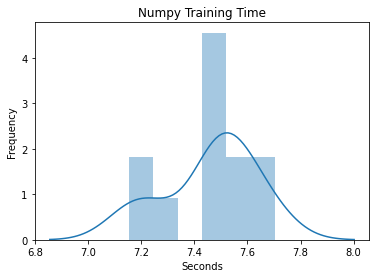

In [25]:
# Multiple 500 to compensate for non-parallelizability
# Since only 1 epoch could occur per trial (with 12 trials)

numpy_times = np.array(numpy_times)
plt.title("Numpy Training Time")
plt.xlabel("Seconds")
plt.ylabel("Frequency")
sn.distplot(numpy_times)
plt.show()

In [26]:
np.mean(numpy_times), np.std(numpy_times), np.var(numpy_times)

(7.459000865618388, 0.16405731899383305, 0.026914803915444294)

In [27]:
np.var(numpy_times/500)

1.0765921566177716e-07

In [28]:
np.mean(numpy_times), np.std(numpy_times), np.var(numpy_times)

(7.459000865618388, 0.16405731899383305, 0.026914803915444294)

In [33]:
from scipy import stats
stats.ttest_ind(numpy_times,tensorflow_times)

Ttest_indResult(statistic=121.47908898223567, pvalue=1.338415821823806e-32)

In [34]:
stats.ttest_ind(pytorch_times,tensorflow_times)

Ttest_indResult(statistic=88.78553208906968, pvalue=1.3066430242910028e-29)